# Analyze Results

Overall, the model does very well (RMSE of only 2.0291 years on the test set!). However, it is still worthwhile to explore the results and see the model's strengths and weaknesses. 

In [1]:
# global imports
import numpy as np
import pandas as pd
# visualizations 
import altair as alt
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
# permuted importance
from sklearn.inspection import permutation_importance
# global surrogate model
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error
# LIME
import lime
import lime.lime_tabular
# shapley value
import shap

# supress scientific notation
pd.options.display.float_format = '{:.2f}'.format
# show all columns
pd.set_option('display.max_columns', None)

## Import Data

In [2]:
%store -r dfs
# obtain test data
train = dfs[0]
test = dfs[1]

In [3]:
%store -r model_lst
# obtain predictions
train_predictions = model_lst[1]
test_predictions = model_lst[2]
# obtain model
gb_model = model_lst[0]

In [4]:
%store -r scaled_dfs
# import data frames from machine learning
X_train = scaled_dfs[0]
y_train = scaled_dfs[1]
X_test = scaled_dfs[2]
y_test = scaled_dfs[3]

## Absolute Difference Between Predicted and Observed

I explored the data to determine which types of observations perform particularly well or poorly with the model.

In [5]:
# add predictions to test data
test['Predictions'] = test_predictions
# get absolute difference
test['Difference'] = test['LifeExpectancy']-test['Predictions']
test['AbsDiff'] = test['Difference'].abs()
# drop extra columns
test.drop(columns=['Year','Thinness5_9'],inplace=True)
# output data frame
test.head()

Status  LifeExpectancy  Alcohol  PercentExpenditure  HepatitisB  \
2008  Developing           74.90     5.14              885.99       95.00   
825   Developing           71.20     2.83               52.30       99.00   
605   Developing           59.50     0.08               29.42       54.50   
2844  Developing           71.20     0.85              457.97       63.00   
1861  Developing           74.50     3.55              473.12       98.00   

      Measles   BMI  Polio  TotalExpenditure  Diphtheria  HIV/AIDS     GDP  \
2008        0 53.60  94.00              5.18       95.00      0.10 6387.79   
825         0  5.80  99.00              6.32       99.00      0.30  334.84   
605         0 18.00  98.00              3.39       89.00      0.10  433.27   
2844        0 49.90  65.00              3.85       65.00      0.10 3275.92   
1861        0 53.20  99.00              9.40       98.00      0.10 1975.46   

      Population  Thinness1_19  IncomeComposition  Schooling  \
2008  3158966.00          1.10               0.72      13.40   
825    683475.00          1.80               0.66      12.90   
605    569479.00          7.70               0.00       8.80   
2844   241871.00          1.50               0.59      10.80   
1861   613997.00          1.80               0.64      11.60   

                         Region  Predictions  Difference  AbsDiff  
2008  Latin America & Caribbean        75.23       -0.33     0.33  
825   Latin America & Caribbean        74.11       -2.91     2.91  
605          Sub-Saharan Africa        61.55       -2.05     2.05  
2844        East Asia & Pacific        72.16       -0.96     0.96  
1861  Latin America & Caribbean        74.11        0.39     0.39

### Categorical Variables

In [6]:
# function for visualizing absolute difference for categorical variables
def abs_diff_violin(var,Width):
    alt.Chart(test,title='Violin Plot Absolute Difference').transform_density(
        'AbsDiff',
        as_=['AbsDiff', 'density'],
        groupby=[var]
    ).mark_area(orient='horizontal').encode(
        y=alt.Y('AbsDiff:Q',title='Absolute Difference'),
        color=var,
        x=alt.X(
            'density:Q',
            stack='center',
            impute=None,
            title=None,
            axis=alt.Axis(labels=False, values=[0],grid=False, ticks=True)
        ),
        column=alt.Column(
            var,
            header=alt.Header(
                labelOrient='bottom',
                labelAngle=-90,
                labelPadding=0,
                labelAlign='right')
        )
    ).properties(
        width=Width
    ).configure_facet(
        spacing=0
    ).configure_view(
        stroke=None
    ).display()

In [7]:
# create violin plot for status
abs_diff_violin('Status',300)

alt.Chart(...)

The model performs similarly for both values of `Status`.

In [8]:
# create violin plot for region
abs_diff_violin('Region',100)

alt.Chart(...)

The model predicts most accurately for North America and South Asia. It performs the worst for Sub-Saharan Africa, Middle East and North Africa, and Europe and Central Asia. 

The regions with the worst performance cover countries that have a wide variety of life expectancies, so it seems reasonable that the model would have issues with these areas.

## Numeric Variables

In [9]:
# create lists
lst_of_charts = []
all_columns = test.select_dtypes(include=np.number).columns.tolist()
response_columns = ['LifeExpectancy','Predictions','Difference','AbsDiff']
columns = [col for col in all_columns if col not in response_columns]
# create charts
for col in columns:
    chart = alt.Chart(test, title='Histogram of '+str(col)).mark_bar().encode(
        alt.X(col,bin=True),
        y='mean(AbsDiff):Q'
    ).properties(
        width=165,
        height=165
    )
    lst_of_charts.append(chart)
# output charts
alt.vconcat((lst_of_charts[0]|lst_of_charts[1]|lst_of_charts[2]|lst_of_charts[3]),
            (lst_of_charts[4]|lst_of_charts[5]|lst_of_charts[6]|lst_of_charts[7]),
            (lst_of_charts[8]|lst_of_charts[9]|lst_of_charts[10]|lst_of_charts[11]),
            (lst_of_charts[12]|lst_of_charts[13]))

alt.VConcatChart(...)

The model performs similarly for all levels of alcohol and schooling. It predicts very well for large values of BMI and thinness. It has difficulties predicting middle values of expenditure on health as a percent of GDP, hepatitus B, polio immunization coverage, diptheria immunization coverage, and HIV/AIDS. 

## Global Model Interpretability

In [10]:
# variables for feature importance
variable = X_train.columns

# function for printing feature importance
def print_feature_importance(importances):
    # zip together
    zipped = zip(importances,variable)
    feat_importances = sorted(zipped)
    # output feature importance
    for feature in feat_importances:
        print(feature[1],': ',feature[0])
        
# function for plotting feature importance
def plot_feature_importance(importances):
    # create data frame
    importance_df = pd.DataFrame({'Variable':variable,'Importance':importances})
    # create bar chart
    alt.Chart(importance_df,title='Bar Chart of Feature Importance').mark_bar().encode(
        x=alt.X('Variable:N',sort='y'),
        y='Importance:Q'
    ).properties(
        width=500,
        height=300
    ).display()

### Feature Importance

Feature importance for each tree is calculated as $\frac{N_{parent}}{N}metric_{parent}-\frac{N_{right}}{N_{parent}}metric_{right}-\frac{N_{left}}{N_{parent}}metric_{left}$, and this metric gets averaged over all trees. Feature importance uses the training data.

In [11]:
# obtain feature importance
feature_importance = gb_model.feature_importances_
# print feature importance
print_feature_importance(feature_importance)

Region_North America :  0.00012508980378222597
Region_South Asia :  0.00027573743874612615
Region_Middle East & North Africa :  0.0008947438950863178
Region_Latin America & Caribbean :  0.0033000095351710403
Region_Europe & Central Asia :  0.003783923497691004
Measles :  0.007420597258653234
Population :  0.008095750474849941
HepatitisB :  0.009580413305215276
PercentExpenditure :  0.011181779649114433
Polio :  0.014066273058858604
TotalExpenditure :  0.016809585401358
Alcohol :  0.017463880081336997
Diphtheria :  0.018286575567201344
Status_Developing :  0.01965937843717777
GDP :  0.03242893614750072
BMI :  0.034061298645379705
Thinness1_19 :  0.03521957028484361
Schooling :  0.08706208951026029
Region_Sub-Saharan Africa :  0.12677581364823926
HIV/AIDS :  0.23343819171471392
IncomeComposition :  0.32007036264482014


In [12]:
# plot feature importance
plot_feature_importance(feature_importance)

alt.Chart(...)

Income composition of resources, HIV/AIDS, and whether observations are in sub-Sahara Africa are the most important features for determining life expectancy according to the feature importance. 

### Permutated Importance

The permuted feature importance is $i_j = rmse - \frac{1}{K}\sum_{k=1}^Krmse_{k,j}$. When doing this calculation, the $j$th predictor gets shuffled and all other columns are left inplace. Then, the accuracy of the prediction is assessed with the $j$th column shuffled. If the $j$th column is important, the accuracy will worsen. 

In [13]:
# obtain permuted feature importance
permutation = permutation_importance(gb_model,X_test,y_test,random_state=614,
                                     scoring='neg_root_mean_squared_error')
# print feature importance
print_feature_importance(permutation['importances_mean'])

Region_North America :  0.001428257996637239
Region_South Asia :  0.0017099218036643825
Region_Middle East & North Africa :  0.009147290163175637
Region_Latin America & Caribbean :  0.0563868627543048
Region_Europe & Central Asia :  0.059116275673918216
Population :  0.06569834097599436
Measles :  0.08333295507416123
HepatitisB :  0.08415827766093029
PercentExpenditure :  0.10490174483765821
Status_Developing :  0.12107187723700355
GDP :  0.12994177793460215
Polio :  0.24895957280505812
TotalExpenditure :  0.27158125149831447
Diphtheria :  0.2759979148677353
Alcohol :  0.296813843138832
BMI :  0.3647862509749851
Thinness1_19 :  0.6838104780212508
Schooling :  0.6935619742271406
Region_Sub-Saharan Africa :  1.3431138832767242
HIV/AIDS :  2.5170829658254705
IncomeComposition :  3.1723858397722813


In [14]:
# plot feature importance
plot_feature_importance(permutation['importances_mean'])

alt.Chart(...)

Similarly, income compensation, HIV/AIDS, and whether observations are in sub-Sahara Africa are the most important features for determining life expectancy according to the permuted feature importance. However, the weights of these variables differs from the original feature importance. 

### Global Surrogate Method

Decision trees are more interpretable than gradient boosted trees. Because of this, I trained a decision tree on the predictions of the GBT model to understand how the GBT model makes predictions. 

Decision trees use recursive binary splitting to determine cutpoints. They consider all possible cutpoint values for each predictor and choose the cut that minimizes the MSE at the given step. This splits $R_j$ into $R_{j1}=\{x|x_i<S\}$ and $R_{j2}=\{x|x_i\geq S\}$.

***Cross Validation***

Tune `max_depth`.

In [15]:
# dt model
dt = DecisionTreeRegressor(random_state=316)
# parameter grid
dt_pars = {'max_depth':[3,5,10,15]}
# grid search
dt_grid = GridSearchCV(estimator=dt,
                       param_grid=dt_pars,
                       cv=KFold(random_state=130,shuffle=True),
                       scoring='neg_root_mean_squared_error')\
                       .fit(X_train, train_predictions)
# output best parameters from grid search
dt_grid.best_params_

{'max_depth': 10}

***Final Model***

In [16]:
# fit the model
dt_model = DecisionTreeRegressor(random_state=316,max_depth=10)
dt_model.fit(X_train,train_predictions)
# create predictions
dt_pred = dt_model.predict(X_train)
# print the RMSE on the train
print('RMSE for decision tree: ',mean_squared_error(train_predictions,dt_pred,squared=False))

RMSE for decision tree:  1.3592655700389245


***Plot Tree***

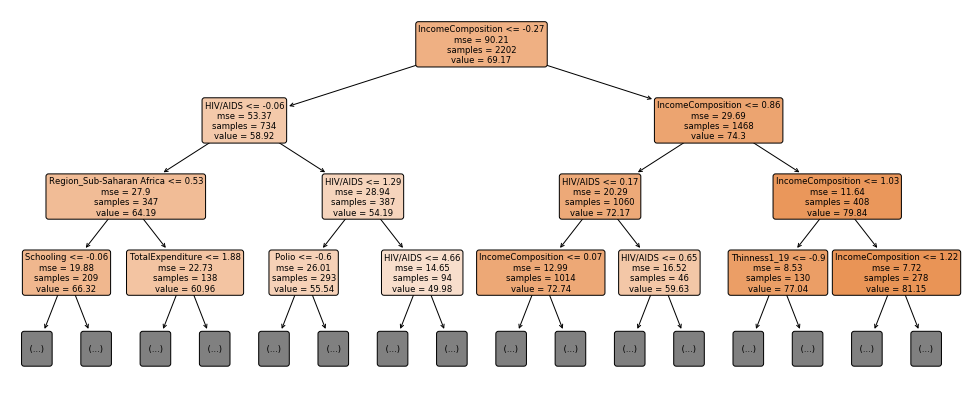

In [17]:
# plot the decision tree
plt.figure(figsize=(17,7))
plot_tree(dt_model,feature_names=variable,filled=True,max_depth=3,fontsize=8.5,precision=2,rounded=True)
plt.show()

The first three layers of the decision tree only consist of variables that were selected as "most important" by the feature importance. The dataset was scaled so the numbers are not interpretable. However, these values could be unscaled and interpreted if the scaling transformation gets saved (I'll do this in the future). 

***Feature Importances***

In [18]:
# obtain feature importance
dt_feature_importance = dt_model.feature_importances_
# print feature importance
print_feature_importance(dt_feature_importance)

Region_North America :  0.0
Region_South Asia :  0.0
Region_Latin America & Caribbean :  1.3892696408332342e-05
Status_Developing :  0.00011422741053444852
Region_Europe & Central Asia :  0.0008517411966225607
HepatitisB :  0.0017309962670790688
Region_Middle East & North Africa :  0.0026401101054505287
Measles :  0.002680275962497326
PercentExpenditure :  0.0032205327347915214
GDP :  0.004479791665009848
Population :  0.004527387795038621
BMI :  0.008492429218066026
Diphtheria :  0.009310459308743298
Polio :  0.01232663359461952
Alcohol :  0.01279780103942744
Schooling :  0.015062408760266674
Thinness1_19 :  0.015169460904335668
Region_Sub-Saharan Africa :  0.016522108618670584
TotalExpenditure :  0.019234799657522027
HIV/AIDS :  0.15216520047185708
IncomeComposition :  0.7186597425930595


In [19]:
# plot feature importance
plot_feature_importance(dt_feature_importance)

alt.Chart(...)

The location feature about Sub-Saharan Africa is not as significant in the decision tree model in comparison to the feature importances. 

## Local Model Interpretability

I will look at the data points for the United States in 2015 (train dataset) and in 2009 (test dataset).

### Locally Interpretable Model-Agnostic Explanations

LIME takes an observation and generates data from a normal distribution around this observation. Data points that are closer to the given observation get assigned larger weights. Then, an interpretable linear model (ridge regression) gets trained on the fake data to approximate the actual machine learning model near the given point. This model is created using the equation $\epsilon(x)=\underset{g\in G}{\arg\min} L(f,g,\pi_x)+\Omega(g)$ where $x$ is a given data point, $f$ is the gradient boosted model, $g$ is the optimal LIME model, $\pi_x$ is the proximity measure, $L$ gives the optimal fit, and $\Omega$ is the complexity term. The unfaithfulness of the model is minimized and the complexity of the model is low to make it interpretable. The final prediction is made with sum the intercept and product of predictor values and weights given from $\epsilon(x)$. 

In [20]:
# create explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                        feature_names=list(variable),
                                                        mode='regression',
                                                        kernel_width=1,
                                                        random_state=102,
                                                        verbose=True)

***2015***

In [21]:
# examine 2015 variable
exp_train = lime_explainer.explain_instance(X_train.loc[2794],gb_model.predict)
exp_train.show_in_notebook(show_table=True)

Intercept 63.30645466349771
Prediction_local [76.81081142]
Right: 78.88020593306332


In [22]:
# print true value
print("True value: ",y_train.loc[2794].values[0])

True value:  78.9


The LIME prediction is close to the gradient boosted tree prediction and the actual prediction, meaning it is a good measurement. Income compensation and the geographic location of the United States are important predictors for the 2015 model.

***2009***

In [23]:
# examine 2009 variable
exp_test = lime_explainer.explain_instance(X_test.loc[2800],gb_model.predict)
exp_test.show_in_notebook(show_table=True)

Intercept 63.40253434287129
Prediction_local [76.89316709]
Right: 79.26711802516675


In [24]:
# print true value
print("True value: ",y_test.loc[2800].values[0])

True value:  78.1


Again, the LIME model prediction is close to the gradient boosted tree prediction and the actual prediction. Also, the income compensation and geographic location of the United States proves to be important features for making the prediction. 

### Shapley Additive exPlanation

Derived from Game Theory, the Shapley value assumes each variable of a data point is a player in a game. The weight of each player is determined by average marginal contribution of the player over all possible coalitions. The Shapley value is computed as $\phi_i(f,x)=\sum_{z'\in x'}\frac{|z'|!(M-|z'|-1)!}{M!}[f_x(z')-f_x(z'\setminus i)]$ where $M$ the size of the full coalition, $z'$ is the subset of the coalition that doesn't include player $i$ as indicator variables for whether a feature is "present" or "not present," and $f$ is the prediction function. 

I used the tree SHAP algorithm because the final model was a gradient boosted tree. This algorithm gets expected predictions for all subsets in decision trees, then it aggregates across the decision trees. SHAP predictions are accurate and consistent, making them good for finding model interpretability. 

#### 2015 Train Data

In [35]:
# create explainer
shap_explainer = shap.TreeExplainer(gb_model,feature_pertubration='tree_path_dependent')
shap_values_train = shap_explainer.shap_values(X_train)

***Global Interpretation***

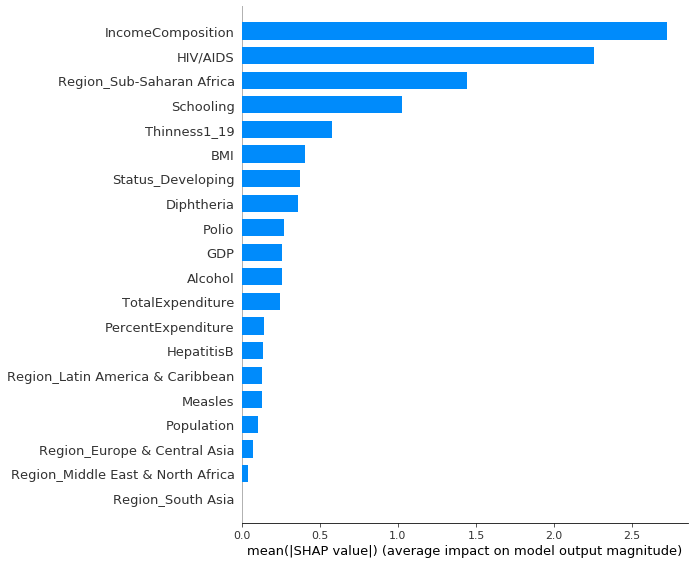

In [26]:
# create bar summary plot
shap.summary_plot(shap_values_train,X_train,plot_type='bar')

The plot shows income composition of resources, HIV/AIDS, and whether observations are in Sub-Saharan Africa are important predictors. 

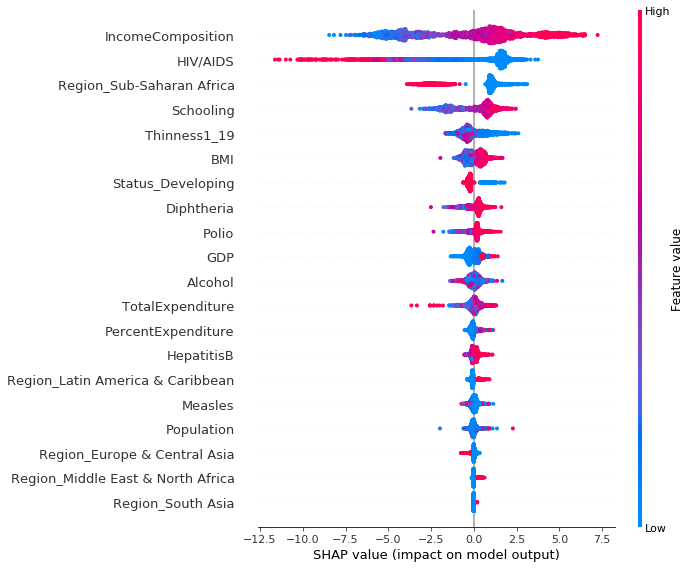

In [27]:
# create summary plot
shap.summary_plot(shap_values_train,X_train)

***Local Interpretation***

In [28]:
# get index 
X_train.index.get_loc(2794)

729

In [29]:
# initialize javascript
shap.initjs()
# create force plot
shap.force_plot(shap_explainer.expected_value,shap_values_train[729],
                features=X_train.loc[2794],
                feature_names=list(variable))

The SHAP model shows that income composition and HIV/AIDS are important predictors for the 2015 data point. Most predictors increased the life expectancy prediction. However, total expenditure, expendiure on health as a percent of GDP, and population size decreased the prediction for this data point. These variables should be targeted by public health officials to increase life expectancy in the United States. 

#### 2009 Test Data

In [30]:
# create explainer
shap_values_test = shap_explainer.shap_values(X_test)

***Global Interpretation***

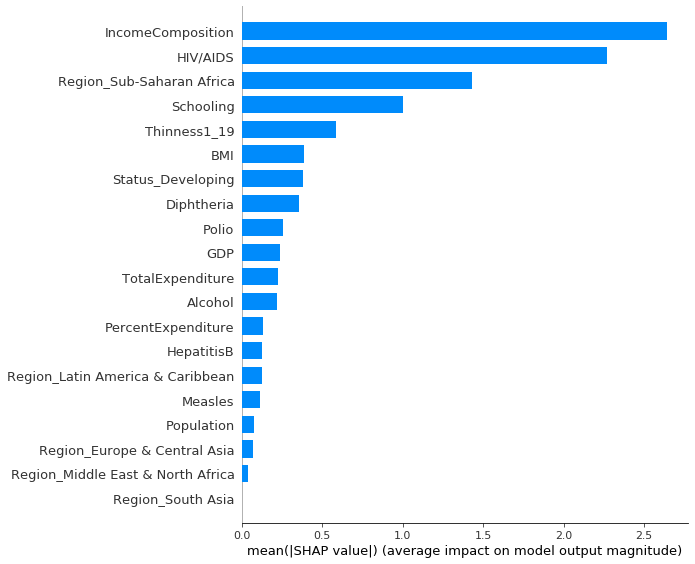

In [31]:
# create bar summary plot
shap.summary_plot(shap_values_test,X_test,plot_type='bar')

The plot shows income composition of resources, HIV/AIDS, and whether observations are in Sub-Saharan Africa are important predictors. 

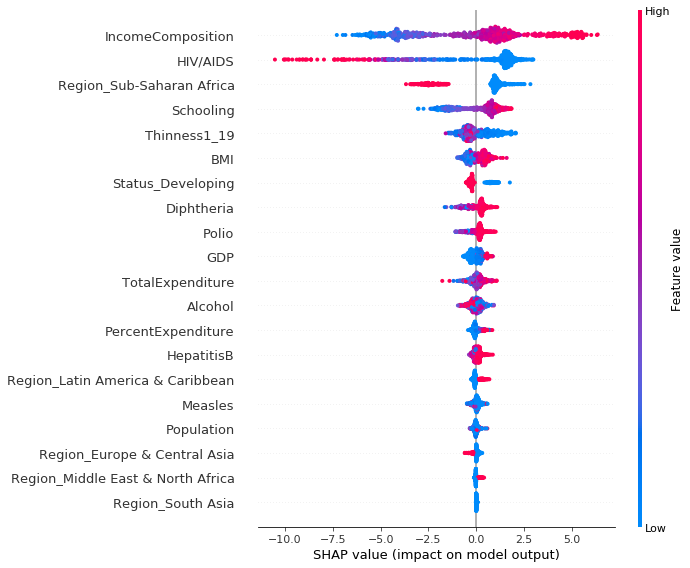

In [32]:
# create summary plot
shap.summary_plot(shap_values_test,X_test)

***Local Interpretation***

In [33]:
# get index 
X_test.index.get_loc(2800)

514

In [34]:
# create force plot
shap.force_plot(shap_explainer.expected_value,shap_values_test[514],
                features=X_test.loc[2800],
                feature_names=list(variable))

The 2009 data shows most predictors increase the life expectancy prediction. The predictors that decrease the life expectancy prediction are very small. Therefore, it seems reasonable to believe that the life expectancy in United States is almost at a maximum level.